In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.integrate
import time

import jax
import jax.numpy as jnp
import jax.scipy as jsp
import diffrax
from jax.scipy import optimize

In [2]:
WL = []
biasL = []
costL = []
training_success_list = []
success_list = []

WL.append(np.load('WLulN74.npy'))
biasL.append(np.load('biasLulN74.npy'))
costL.append(np.load('costLulN74.npy'))
training_success_list.append(np.load('training_success_listulN74.npy'))
success_list.append(np.load('success_listulN74.npy'))

WL.append(np.load('WLulN79.npy'))
biasL.append(np.load('biasLulN79.npy'))
costL.append(np.load('costLulN79.npy'))
training_success_list.append(np.load('training_success_listulN79.npy'))
success_list.append(np.load('success_listulN79.npy'))

WL.append(np.load('WLulN94.npy'))
biasL.append(np.load('biasLulN94.npy'))
costL.append(np.load('costLulN94.npy'))
training_success_list.append(np.load('training_success_listulN94.npy'))
success_list.append(np.load('success_listulN94.npy'))

WL.append(np.load('WLulN124.npy'))
biasL.append(np.load('biasLulN124.npy'))
costL.append(np.load('costLulN124.npy'))
training_success_list.append(np.load('training_success_listulN124.npy'))
success_list.append(np.load('success_listulN124.npy'))

WL.append(np.load('WLulN174.npy'))
biasL.append(np.load('biasLulN174.npy'))
costL.append(np.load('costLulN174.npy'))
training_success_list.append(np.load('training_success_listulN174.npy'))
success_list.append(np.load('success_listulN174.npy'))

WL.append(np.load('WLulN274.npy'))
biasL.append(np.load('biasLulN274.npy'))
costL.append(np.load('costLulN274.npy'))
training_success_list.append(np.load('training_success_listulN274.npy'))
success_list.append(np.load('success_listulN274.npy'))

WL.append(np.load('WLulN374.npy'))
biasL.append(np.load('biasLulN374.npy'))
costL.append(np.load('costLulN374.npy'))
training_success_list.append(np.load('training_success_listulN374.npy'))
success_list.append(np.load('success_listulN374.npy'))

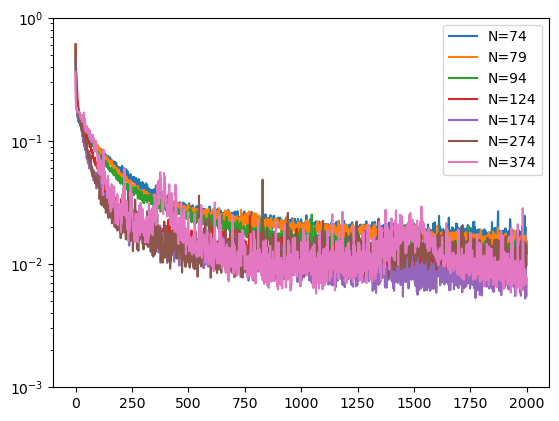

In [3]:
N_list = [74, 79, 94, 124, 174, 274, 374]

N_epoch = costL[0].shape[0]
test_W_ind = np.arange(0,N_epoch+1, 5)

for k in range(0, len(N_list)):
    plt.plot(np.arange(0,N_epoch), costL[k], label='N={0}'.format(N_list[k]))
    
plt.ylim(0.001,1)
plt.yscale('log')
plt.legend()

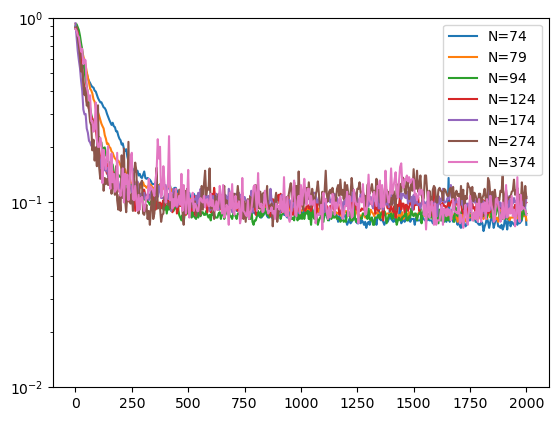

In [4]:
N_list = [74, 79, 94, 124, 174, 274, 374]

N_epoch = costL[0].shape[0]
test_W_ind = np.arange(0,N_epoch+1, 5)

for k in range(0, len(N_list)):
    plt.plot(test_W_ind, 1-success_list[k], label='N={0}'.format(N_list[k]))

plt.ylim(0.01,1)
plt.yscale('log')
plt.legend()

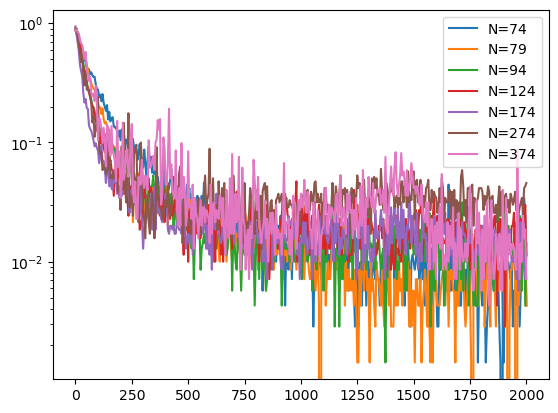

In [5]:
for k in range(0, len(N_list)):
    plt.plot(test_W_ind, 1-training_success_list[k], label='N={0}'.format(N_list[k]))
    
plt.yscale('log')
plt.legend()

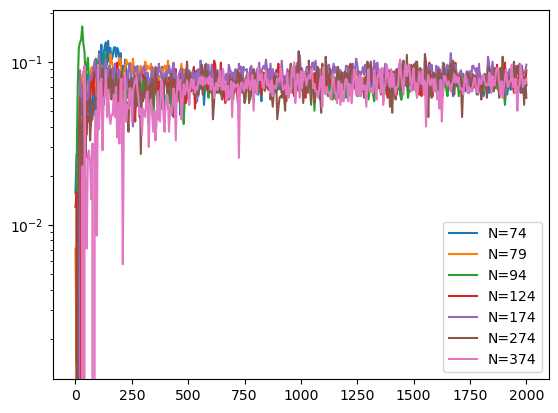

In [6]:
for k in range(0, len(N_list)):
    plt.plot(test_W_ind, training_success_list[k]-success_list[k], label='N={0}'.format(N_list[k]))
    
plt.yscale('log')
plt.legend()

In [7]:
N_list = [74, 79, 94, 124, 174, 274, 374]
phase1L = []
phase0L = []

for k in range(0, len(N_list)):
    phase0L.append(np.load("test_phase0ulN{0}.npy".format(N_list[k])))
    phase1L.append(np.load("test_phase1ulN{0}.npy".format(N_list[k])))

In [8]:
def h_entropy(x):
    if x==0: 
        return 0
    else:
        return -x*np.log2(x)
        
vfun = np.vectorize(h_entropy)

def calculate_cond_entropy(phaseL_0, phaseL_1, digits, output_index):
    
    # Calculate conditional entropy for output phase
    prob_mat_list = 1 + np.sin(phaseL_1[...,output_index])
    N_slice, N_data = prob_mat_list.shape[0], prob_mat_list.shape[1]
    prob_mat_list = prob_mat_list.reshape(N_slice, len(digits), int(N_data/len(digits)), len(digits))
    
    reg_prob = np.zeros(prob_mat_list.shape)
    for k in range(0,len(digits)):
        reg_prob[...,k] = prob_mat_list[...,k]/np.sum(prob_mat_list, axis=3)
    
    reg_prob = np.mean(reg_prob, axis=2)
    H_mat = np.sum(vfun(reg_prob*np.eye(len(digits), len(digits))), axis=2)
    H_mean = np.mean(H_mat, axis=1)
    
    # Calculate conditional entropy for inference result
    res = np.transpose(np.argmax(prob_mat_list,axis=-1), [0,2,1])
    output = np.tensordot(np.ones(res.shape[0:-1]), np.arange(0,len(digits)),0) == res
    
    output_mat = np.zeros([N_slice,len(digits),len(digits)])

    for k in range(0,len(digits)):
        output_mat[:,:,k] = np.sum(res==k*np.ones(res.shape), axis=1)/(N_data/len(digits))
    
    Inf_H_mat = vfun(np.sum(output_mat*np.eye(len(digits),len(digits)), axis=2))
    Inf_H_mean = np.mean(Inf_H_mat, axis=1)
    
    return H_mat, H_mean, Inf_H_mat, Inf_H_mean, output_mat

In [9]:
digits = [0,1,2,3,4,5,6,7,8,9]

for k in range(0,len(N_list)):
    phaseL_0 = phase0L[k]
    phaseL_1 = phase1L[k]
    input_index = jnp.arange(0,64)
    output_index = jnp.arange(N_list[k]-10, N_list[k])
    H_mat, H_mean, Inf_H_mat, Inf_H_mean, output_mat = calculate_cond_entropy(phaseL_0, phaseL_1, digits, output_index)
    plt.plot(H_mean, label=r'N={0}'.format(N_list[k]))

plt.ylim(0.1,0.5)
plt.xlim(0,400)
plt.yscale('log')
plt.legend()

2023-11-15 14:30:31.171928: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:429] Could not create cudnn handle: CUDNN_STATUS_NOT_INITIALIZED
2023-11-15 14:30:31.172109: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:438] Possibly insufficient driver version: 470.182.3


XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.

In [ ]:
# Calculate the entropy of confusion matrix

def get_confusion_mat(phase_1, output_index, test_batch_size):
    # get the confusion matrix for single sets of output
    phase_out = phase_1[:, output_index]
    results = jnp.argmax(1+jnp.sin(phase_out), axis=1).reshape(10, test_batch_size)
    
    confusion_mat = jnp.zeros([10,10])
    # terms in confusion_mat[i,j] refers the probability of taking input i as j
    for k in range(0,10):
        confusion_mat = confusion_mat.at[:,k].set(jnp.sum(results==k, axis=1))
    return confusion_mat/test_batch_size

def get_entropy(confusion_mat):
    H_terms = -confusion_mat * jnp.log2(confusion_mat+1e-15)
    return jnp.sum(H_terms, axis=1)

In [ ]:
for k in range(0,len(N_list)):
    N = N_list[k]
    output_index = np.arange(N-10, N)
    input_index = jnp.arange(0,64)
    
    phaseL_1 = phase1L[k]
    
    print(phaseL_1.shape)
    
    res_L = jax.vmap(get_confusion_mat, (0,None,None))(phaseL_1, output_index, 70)
    H_L = jax.vmap(get_entropy)(res_L)
    plt.plot(jnp.sum(H_L, axis=1)/10, label=r'N={0}'.format(N_list[k]))

plt.ylim(0.1,2.5)
plt.xlim(0,400)
plt.yscale('log')
plt.legend()

In [ ]:
for k in range(0,10):
    plt.plot(H_L[:,k], label=r'N={0}'.format(k))

In [ ]:
fig, ax = plt.subplots(10,1, figsize=(3,20))
for k in range(0,10):
    ax[k].plot(H_L[:,k], label=r'N={0}'.format(k))
    ax[k].set_ylim(0,2.5)